# Carvana Image Masking Challenge

https://www.kaggle.com/c/carvana-image-masking-challenge

In [4]:
IMG_ROWS = 480
IMG_COLS = 320

TEST_IMG_ROWS = 1918
TEST_IMG_COLS = 1280

## Загружаем исходные изображения

In [9]:
import cv2
import numpy as np
from scipy import ndimage
from glob import glob

SAMPLE = 5000

train_img_paths = sorted(glob('E:/aml/train/*.jpg'))[:SAMPLE]
train_mask_paths = sorted(glob('E:/aml/train_masks/*.gif'))[:SAMPLE]

train_imgs = np.array([cv2.resize(ndimage.imread(path), (IMG_ROWS, IMG_COLS))
                        for path in train_img_paths])

train_masks = np.array([cv2.resize(ndimage.imread(path, mode = 'L'), (IMG_ROWS, IMG_COLS))
                        for path in train_mask_paths])

train_masks = train_masks.astype(np.float32)
train_masks[train_masks<=127] = 0.
train_masks[train_masks>127] = 1.
train_masks = np.reshape(train_masks, (*train_masks.shape, 1))

print("len_train_img_paths", len(train_img_paths))

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  if sys.path[0] == '':
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  from ipykernel import kernelapp as app


len_train_img_paths 5000


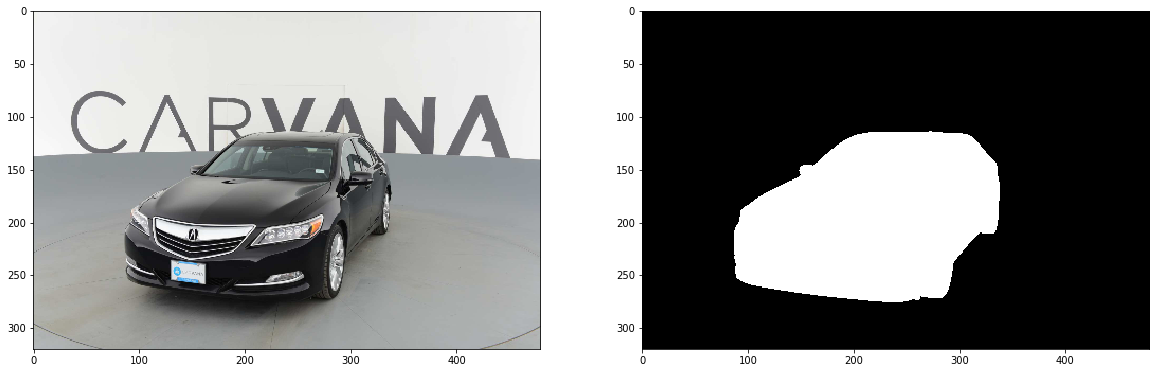

In [12]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(0, figsize=(20, 20))
fig.add_subplot(1, 2, 1)
plt.imshow(train_imgs[1])
fig.add_subplot(1, 2, 2)
plt.imshow(np.squeeze(train_masks[1]), cmap='gray')

## Инициализируем архитектуру U-Net

In [13]:
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Conv2DTranspose
from keras.layers import BatchNormalization
from keras.layers import concatenate
from keras.models import Model

inputs = Input((IMG_COLS, IMG_ROWS, 3))
bnorm1 = BatchNormalization()(inputs)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(bnorm1)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

model = Model(inputs=[inputs], outputs=[conv10])

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


In [14]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 320, 480, 3)  0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 320, 480, 3)  12          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 320, 480, 32) 896         batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 320, 480, 32) 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_poolin

## Задаем функцию потерь

In [15]:
from keras import backend as K
from keras.losses import binary_crossentropy

SMOOTH = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + SMOOTH) / (K.sum(y_true_f) + K.sum(y_pred_f) + SMOOTH)

def bce_dice_loss(y_true, y_pred):
    return 0.5 * binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

## Запускаем процесс обучения

In [16]:
from keras.optimizers import Adam
model.compile(Adam(lr=1e-4),
              bce_dice_loss,
              metrics=[binary_crossentropy, dice_coef])

In [ ]:
model.fit(train_imgs[50:], train_masks[50:],
          batch_size=12, epochs=10, 
          validation_data=(train_imgs[:50], train_masks[:50]))

Instructions for updating:
Use tf.cast instead.
Train on 4950 samples, validate on 50 samples
Epoch 1/10
1596/4950 [========>.....................] - ETA: 2:15:13 - loss: -0.5205 - binary_crossentropy: 0.3313 - dice_coef: 0.6861

## Предсказание модели

In [14]:
test_paths = sorted(glob('./data/test/*.jpg'))

def test_img_generator(test_paths):
    while True:
        for path in test_paths:
            yield np.array([cv2.resize(ndimage.imread(path), (IMG_ROWS, IMG_COLS))])

In [15]:
pred = model.predict_generator(test_img_generator(test_paths[:10]), len(test_paths[:10]))

## Визуализируем результат

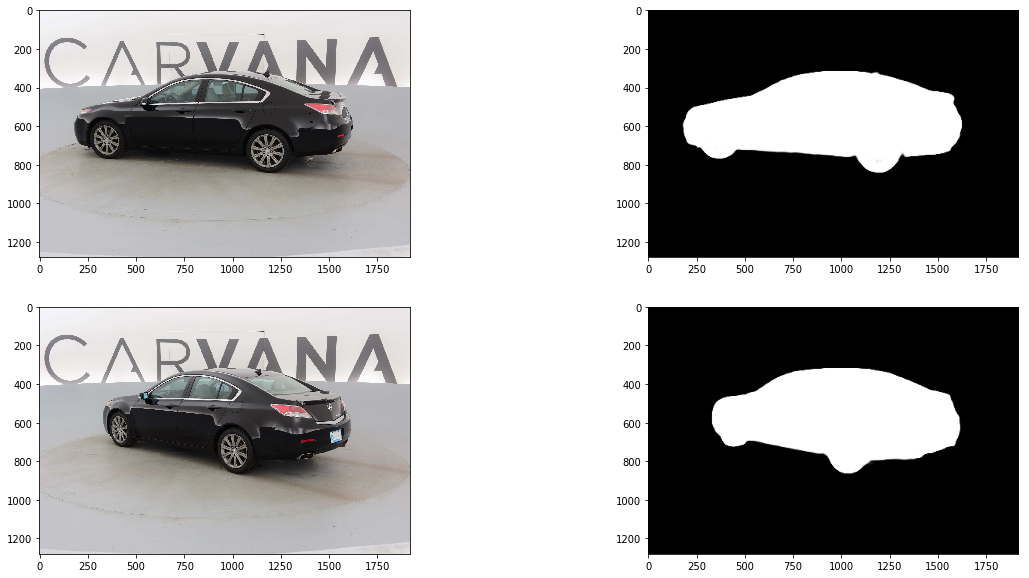

In [28]:
fig = plt.figure(0, figsize=(20, 10))
k = 5
fig.add_subplot(2, 2, 1)
plt.imshow(ndimage.imread(test_paths[k]))
fig.add_subplot(2, 2, 2)
plt.imshow(np.squeeze(cv2.resize(pred[k], (TEST_IMG_ROWS, TEST_IMG_COLS))), cmap='gray')
fig.add_subplot(2, 2, 3)
plt.imshow(ndimage.imread(test_paths[k+1]))
fig.add_subplot(2, 2, 4)
plt.imshow(np.squeeze(cv2.resize(pred[k+1], (TEST_IMG_ROWS, TEST_IMG_COLS))), cmap='gray')

## Подготавливаем данные для отправки

In [23]:
def rle_encode(mask):
    pixels = mask.flatten()
    pixels[0] = 0
    pixels[-1] = 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
    runs[1::2] = runs[1::2] - runs[:-1:2]
    return runs

In [24]:
with open('submit.txt', 'w') as dst:
    dst.write('img,rle_mask\n')
    for path in test_paths:
        img = np.array([cv2.resize(ndimage.imread(path), (IMG_ROWS, IMG_COLS))])
        pred_mask = model.predict(img)[0]
        bin_mask = 255. * cv2.resize(pred_mask, (TEST_IMG_ROWS, TEST_IMG_COLS))
        bin_mask[bin_mask<=127] = 0
        bin_mask[bin_mask>127] = 1
        rle = rle_encode(bin_mask.astype(np.uint8))
        rle = ' '.join(str(x) for x in rle)
        dst.write('%s,%s\n' % (path.split('/')[-1], rle))

In [ ]:
# 20 epochs
# loss: -0.9891 - binary_crossentropy: 0.0077 - dice_coef: 0.9930
# val_loss: -0.9889 - val_binary_crossentropy: 0.0085 - val_dice_coef: 0.9932
# kaggle: 0.9926